# Project: Treasury Bill Pricing and Interest Rate Risk
This project will familiarize students with computing the price of United States Treasury Bills (`T-bills`) and guide students through testing the dependence of the price of `T-bills` to changes in the interest rate and duration of instruments.

### Learning objectives
* Objective 1: First, you'll compute the price of a random `T-bill` and validate your simulated price using Treasury auction data from `2022` and `2023`.
* Objective 2: Next, you'll compute the sensitivity of short- and long-duration `T-bill` prices to changes in the interest rate. Long-duration `T-bills` should be more sensitive to interest rate changes than shorter-duration instruments.

## Setup
We load the [VLQuantitativeFinancePackage.jl](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl) package, and several other external [Julia](https://julialang.org/downloads/https://julialang.org/downloads/) packages, as well as some helper code, by calling the [include(...)](https://docs.julialang.org/en/v1/manual/code-loading/https://docs.julialang.org/en/v1/manual/code-loading/) command on the file `Include.jl`:

In [1]:
include("Include.jl");

### Data
We'll explore `T-bill` prices from United States Treasury auctions between May and August 2023 downloaded using the [Auction query functionality of TreasuryDirect.gov](https://www.treasurydirect.gov/auctions/auction-query/). We load the `CSV` dataset using the `MyTreasuryBillDataSet()` function, which returns the auction data as a `DataFrame`:

In [2]:
dataset = MyTreasuryBillDataSet();

Finally, let's set the dimension of our auction dataset in the `number_of_bills` variable:

In [3]:
number_of_bills = nrow(dataset);

### Constants

In [4]:
number_of_samples = 7;
β₁ = 0.8;
β₂ = 1.2;
β = range(β₁, stop = β₂, length = number_of_samples) |> collect;

## Objective 1: Compute and Verify the Price of a Random Treasury Bill
We begin computing the T-bill price by building a discounting model. In this case, let's construct an instance of the `DiscreteCompoundingModel()` type and store this discount model in the `discount_model` variable:

In [5]:
discount_model = DiscreteCompoundingModel();

Next, select a bill from the `dataset`, by randomly selecting an index from `1...number_of_bills` using the [built-in Julia rand function](https://docs.julialang.org/en/v1/stdlib/Random/#Base.rand):

In [6]:
random_bill_index = rand(1:number_of_bills)
println("Selected bill: $(random_bill_index)")

Selected bill: 22


In [7]:
dataset[random_bill_index,:]

Row,CUSIP,Security Type,Security Term,Auction Date,Issue Date,Maturity Date,Price,Investment Rate
,String15,String7,String7,String15,String15,String15,Float64,Float64
22,912797HU4,Bill,17-Week,08/09/2023,08/15/2023,12/12/2023,98.2447,0.05495


Create an instance of the `MyUSTreasuryZeroCouponBondModel` model, using the `build(...)` method, assuming a par value of `100 USD` and two compounding periods per year. Update the duration `T` and `rate` fields, and use the short-cut syntax to compute the price. Save the updated model in the `zero_coupon_model` variable. 

In [68]:
zero_coupon_model = build(MyUSTreasuryZeroCouponBondModel, (
    par = 100.0, n = 2, 
        
    ### BEGIN SOLUTION    
    T = dataset[random_bill_index, Symbol("Security Term")] |> String |> securityterm,
    rate =  dataset[random_bill_index, Symbol("Investment Rate")]
    ### END SOLUTION    
        
)) |> discount_model;

In [67]:
# Test 1: do the prices agree?
@assert isapprox(zero_coupon_model.price, dataset[random_bill_index,:Price], rtol=1e-4)

## Objective 2: Sensitivity of price to interest rate and term to maturity

Malkiel proposed five theorems that govern the price of fixed-income debt securities, e.g., Treasury Bills, Notes, and Bonds, as a function of the duration and yield values:

* [Malkiel, B. G. (1962). Expectations, Bond Prices, and the Term Structure of Interest Rates. The Quarterly Journal of Economics, 76(2), 197–218. https://doi.org/10.2307/1880816](https://www.jstor.org/stable/1880816https://www.jstor.org/stable/1880816)

Theorem 2 suggests that the greater the term to maturity, the more significant the change in the fixed-income security price for a given change in yield from the nominal yield. Let's test Theorem 2 by simulating prices as a function of interest rate and term to majurity.

### Strategy
Create models for two bills $i$ and $j$ from the `dataset`. Bills $i$ and $j$ should have a significant difference in duration, for example `4 weeks` versus `52 weeks`, and then simulate how the price of these instruments changes as we vary the yeild by the same percentage. Assume a $V_{P} = 100$ USD for both instruments and semiannual compounding.

### Short duration bill
Select the index of a random `4-Week` duration treasury bill, save this index in the variable `i`:

In [38]:
short_duruation_dataset = filter(Symbol("Security Term") => x-> x == "4-Week", dataset)
i = nrow(short_duruation_dataset) |> x-> rand(1:x);
short_duruation_dataset[i,:]

Row,CUSIP,Security Type,Security Term,Auction Date,Issue Date,Maturity Date,Price,Investment Rate
,String15,String7,String7,String15,String15,String15,Float64,Float64
2,912797GU5,Bill,4-Week,08/24/2023,08/29/2023,09/26/2023,99.5889,0.05395


Build an instance `MyUSTreasuryZeroCouponBondModel` to model the random `4-Week` treasury bill, and compute the price using the short-cut syntax:

In [65]:
short_duration_model = build(MyUSTreasuryZeroCouponBondModel, (
    par = 100, n = 2, 
    T = short_duruation_dataset[i, Symbol("Security Term")] |> String |> securityterm,
    rate = short_duruation_dataset[i, Symbol("Investment Rate")],
)) |> discount_model;

##### Check: Is the short duration price similar to the dataset?

In [66]:
# Test 2: do the prices agree?
short_duration_price = short_duration_model.price
@assert isapprox(short_duration_price, short_duruation_dataset[i,:Price], rtol = 1e-3)

### Long duration bill

Select the index of a random `52-Week` duration treasury bill, save this index as the variable `j`:

In [39]:
long_duruation_dataset = filter(Symbol("Security Term") => x-> x == "52-Week", dataset)
j = nrow(long_duruation_dataset) |> x-> rand(1:x);
long_duruation_dataset[j,:]

Row,CUSIP,Security Type,Security Term,Auction Date,Issue Date,Maturity Date,Price,Investment Rate
,String15,String7,String7,String15,String15,String15,Float64,Float64
1,912797GK7,Bill,52-Week,08/08/2023,08/10/2023,08/08/2024,94.8838,0.05351


Build an instance `MyUSTreasuryZeroCouponBondModel` to model the random `52-Week` treasury bill, and compute the price using the short-cut syntax:

In [64]:
long_duration_model = build(MyUSTreasuryZeroCouponBondModel, (
    par = 100, n = 2, 
    T = long_duruation_dataset[j, Symbol("Security Term")] |> String |> securityterm,
    rate = long_duruation_dataset[j, Symbol("Investment Rate")],
)) |> discount_model;

##### Check: Is the long duration price similar to the dataset?

In [63]:
# Test 3: do the prices agree?
long_duration_price = long_duration_model.price
@assert isapprox(long_duration_price, long_duruation_dataset[j,:Price], rtol = 1e-3)

### Compute the change of the short and long-duration prices as a function of the yield 
Compute the price of the short and long-duration notes or bonds using different values for the yield (stored in the `rate` field), and store the results in the `theorem_2_simulation_array` variable. Iterate through each value of the $\beta$ array using a `for` loop. For iteration $i$ of the loop:

* Get a value for the perturbation $\beta_{i}$ from the $\beta$-array, and compute the new effective rate value for each model $\bar{r}_{i} = \beta_{i}\cdot{\bar{r}}$.
* Update the `short_duration_model` and the `long_duration_model` models instances with the new rates (set the `rate` field), and compute the new prices
* Store the $\beta_{i}$ value in column 1, and the percentage difference in price for each instrument in column 2 (short) and column 3 (long) of the `theorem_2_simulation_array`

In [55]:
theorem_2_simulation_array = Array{Float64,2}(undef, number_of_samples, 3);
for i ∈ eachindex(β)
    
    β_value = β[i];
    
    ### BEGIN SOLUTION
    short_duration_model.rate = β_value*(short_duruation_dataset[i, Symbol("Investment Rate")]);
    long_duration_model.rate = β_value*(long_duruation_dataset[j, Symbol("Investment Rate")]);
    new_short_duration_price = short_duration_model |> discount_model |> x-> x.price
    new_long_duration_price = long_duration_model |> discount_model |> x-> x.price
    
    theorem_2_simulation_array[i,1] = β_value
    theorem_2_simulation_array[i,2] = ((new_short_duration_price - short_duration_price)/short_duration_price)*100
    theorem_2_simulation_array[i,3] = ((new_long_duration_price - long_duration_price)/long_duration_price)*100
    ### END SOLUTION
end

#### Visualize

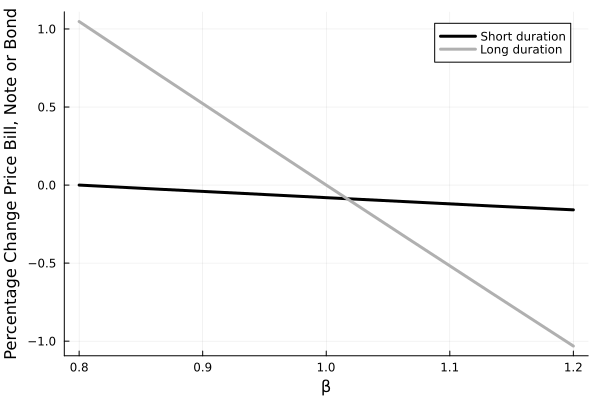

In [56]:
plot(theorem_2_simulation_array[:,1], theorem_2_simulation_array[:,2], label="Short duration", lw=3, c=:black, 
        xlabel="β", ylabel="Percentage Change Price Bill, Note or Bond")
plot!(theorem_2_simulation_array[:,1], theorem_2_simulation_array[:,3], label="Long duration", lw=3, c=:gray69, 
        xlabel="β", ylabel="Percentage Change Price Bill, Note or Bond")